In [129]:
import pandas as pd

df = pd.read_csv("data/weather_data.csv")
timestamp=200

In [130]:
# RNN으로 150일 데이터를 이용하여 151일을 예측하는 모델을 만들어보자.
# 타겟 생성
df["target"] = df["max_Temp"].shift(-1*timestamp)
df = df.dropna()

In [131]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# 데이터 분할
X = df.drop(["date","target"], axis=1)
y = df["target"]

# 50일치 데이터를 보고 1일치 데이터를 예측하는 데이터셋 생성
def create_dataset(X, y, time_steps=timestamp):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 50
X_train, y_train = create_dataset(X, y, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
# # y_train과 y_test도 예측하기
# y_scaler = MinMaxScaler()
# y_train = y_scaler.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
# y_test = y_scaler.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

IndexError: single positional indexer is out-of-bounds

In [ ]:
# pytorch로 LSTM 모델 구성하기
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 50일치 데이터를 보고 1일치 데이터를 예측하는 모델이므로 input_size는 X.shape[1]
model = LSTM(X.shape[1], 64, 2, 1)

# 모델 컴파일
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 학습 함수
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# 평가 함수
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output.squeeze(), target)
            running_loss += loss.item()
    return running_loss / len(test_loader)

# 학습 및 평가
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss = evaluate(model, test_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch [1/100], Train Loss: 273.4312, Test Loss: 177.0699
Epoch [2/100], Train Loss: 145.2325, Test Loss: 128.3594
Epoch [3/100], Train Loss: 111.6278, Test Loss: 114.6943
Epoch [4/100], Train Loss: 101.7889, Test Loss: 112.1981
Epoch [5/100], Train Loss: 99.3463, Test Loss: 112.2334
Epoch [6/100], Train Loss: 98.9675, Test Loss: 112.4010
Epoch [7/100], Train Loss: 97.7024, Test Loss: 108.5864
Epoch [8/100], Train Loss: 91.8328, Test Loss: 91.7215
Epoch [9/100], Train Loss: 78.5552, Test Loss: 84.2739
Epoch [10/100], Train Loss: 73.3036, Test Loss: 68.7310
Epoch [11/100], Train Loss: 63.4102, Test Loss: 61.9091
Epoch [12/100], Train Loss: 59.6645, Test Loss: 72.9871
Epoch [13/100], Train Loss: 48.3209, Test Loss: 43.2780
Epoch [14/100], Train Loss: 39.9093, Test Loss: 36.6712
Epoch [15/100], Train Loss: 35.5589, Test Loss: 37.8746
Epoch [16/100], Train Loss: 33.2230, Test Loss: 36.7064
Epoch [17/100], Train Loss: 31.8418, Test Loss: 33.8995
Epoch [18/100], Train Loss: 30.0658, Test Loss

tensor([[[ 2.6800e+01,  5.0000e+00,  2.9200e+01,  ...,  1.4700e+01,
           0.0000e+00,  1.6600e+01],
         [ 2.9200e+01,  7.6000e+00,  2.7400e+01,  ...,  1.5000e+01,
           1.0600e+02,  1.8200e+01],
         [ 2.1700e+01,  8.4000e+00,  5.5400e+01,  ...,  7.2000e+00,
           0.0000e+00,  1.6800e+01],
         ...,
         [ 2.9200e+01,  1.7100e+01,  3.6800e+01,  ...,  1.0800e+01,
           0.0000e+00,  2.4800e+01],
         [ 3.2400e+01,  1.5600e+01,  3.5500e+01,  ...,  1.6000e+01,
           0.0000e+00,  2.6100e+01],
         [ 3.1500e+01,  1.5700e+01,  3.8100e+01,  ...,  1.2200e+01,
           1.4000e+02,  2.5900e+01]],

        [[ 9.5000e+00, -4.9000e+00,  5.0500e+01,  ...,  4.9000e+00,
           5.9900e+02,  1.0000e+00],
         [ 5.6000e+00, -2.0000e+00,  6.5600e+01,  ...,  2.7000e+00,
           1.8300e+02,  1.0000e+00],
         [ 6.7000e+00, -7.1000e+00,  5.6300e+01,  ...,  6.1000e+00,
           6.1000e+02,  1.1000e+00],
         ...,
         [ 1.1100e+01, -1

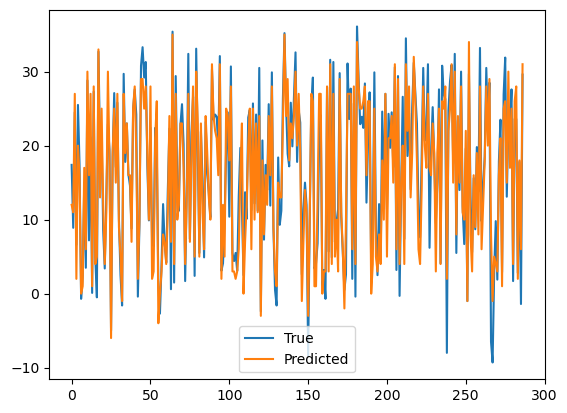

In [ ]:
# 예측
model.eval()
with torch.no_grad():
    inputs = X_test
    print(inputs)
    print(inputs.shape)
    outputs = model(inputs)
    predicted = torch.round(outputs)
    
# 예측 결과를 시각화
import matplotlib.pyplot as plt
plt.plot(y_test, label="True")
plt.plot(predicted, label="Predicted")
plt.legend()
plt.show()

In [ ]:
# 최근 날짜로부터 200일까지의 데이터를 모아서 그 다음날 예측하기
for _ in range(365):
    df = pd.read_csv("data/weather_data.csv")
    df.tail(timestamp) # 해당 데이터에서 date와 target열을 제거한 다음, 50일치 데이터를 (1,50,10)형태로 갖고오기
    last_50 = df.tail(timestamp).drop(["date"], axis=1)
    last_50 = torch.FloatTensor(last_50.values).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        output = model(last_50)
        print(output)
        print(output.item())
        print(f"Predicted Max Temp for Next Day: {output.item()}")
    #df에 예측값 추가하기
    # df["date"].iloc[-1]을 date 타입으로 변환
    df["date"] = pd.to_datetime(df["date"])
    next_date = df["date"].iloc[-1] + pd.DateOffset(days=1)
    new_row = pd.DataFrame({"date": [next_date], "max_Temp": [output.item()]})
    df = pd.concat([df, new_row], ignore_index=True)
    df.to_csv("data/weather_data.csv", index=False)

tensor([[5.6612]])
5.661157608032227
Predicted Max Temp for Next Day: 5.661157608032227
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan
tensor([[nan]])
nan
Predicted Max Temp for Next Day: nan


In [ ]:
df

,date,max_Temp,min_Temp,hum,widdir,wind,rain,sun_Time,sun_Qy,condens_Time,soil_Temp,target
0,2017-01-01 13:00:00,6.100000,-6.3,66.7,148.5,0.5,0.0,232.0,4.2,755.0,0.6,27.9
1,2017-01-02 13:00:00,7.800000,-5.9,66.5,175.1,0.6,0.0,118.0,4.0,697.0,0.7,26.8
2,2017-01-03 13:00:00,6.500000,-4.1,41.8,306.6,2.5,0.0,254.0,5.9,637.0,0.8,25.9
3,2017-01-04 13:00:00,8.100000,-5.4,60.8,293.9,1.4,0.0,241.0,5.4,479.0,0.9,22.5
4,2017-01-05 13:00:00,7.700000,-4.8,65.4,186.1,1.6,0.0,29.0,3.0,464.0,1.1,27.6
...,...,...,...,...,...,...,...,...,...,...,...,...
1479,2023-04-10 13:00:00,18.400000,-1.6,20.5,227.4,1.4,0.0,335.0,12.7,0.0,10.6,15.6
1480,2023-04-12 13:00:00,16.400000,1.0,15.8,283.8,3.5,0.0,344.0,14.3,504.0,12.4,16.6
1481,2023-04-13 13:00:00,19.100000,-1.5,15.9,294.1,1.9,0.0,302.0,10.9,0.0,11.3,21.0
1482,2023-04-14 13:00:00,18.400000,4.0,35.4,260.6,0.3,0.0,136.0,6.1,0.0,12.0,24.1


In [ ]:
# 해당 df의 마지막 날짜 뽑아오기
last_date = df["date"].iloc[-1]
# 13:00 제거
last_date = last_date.split(" ")[0]

In [ ]:
#last_date에서 1일을 더한 날짜 출력
from datetime import datetime, timedelta
last_date = datetime.strptime(last_date, "%Y-%m-%d")
next_date = last_date + timedelta(days=1)
next_date = next_date.strftime("%Y-%m-%d")
print(next_date)

2024-01-31
